In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import array
from pickle import dump
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import tensorflow as tf
import string

In [47]:
# load text to memory
def load_doc(filename): 
# open the file as read only
    file = open(filename, 'r')
# read all text
    text = file.read()
# close the file
    file.close()
    return text

In [3]:

##heuristics for splitting up words
#replace dashes with a white space
#otherwise words based on white space.
#reduce all words to lowercase and remove punctuation from words 
#remove all words that are not alphabetic 
# turn a doc into clean tokens



def clean_doc(doc):
# replace '--' with a space ' '
    doc = doc.replace('--', ' ')
# split into tokens by white space
    tokens = doc.split()
# remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
# remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
# make lower case
    tokens = [word.lower() for word in tokens]
    return tokens


In [48]:
# use GPU to speed up training time through tensforflow
config = tf.ConfigProto()
#only allocate as much GPU memory based on runtime allocations, initially little but allows memory to be extended
config.gpu_options.allow_growth = True


In [5]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()


In [6]:
# load document
in_filename = '/Users/neilwatt/Documents/BIs/PrWeb/2018Posts/October/Word_LSTM/GoneWithWind.txt'
doc = load_doc(in_filename)
print(doc[:200])



Title: Gone With The Wind
Author: Margaret Mitchell (1900-1949)
eBook No.:  0200161.txt
Character set encoding:     ASCII--7 bit
Date first posted: February 2002
Date most recently updated: December


In [7]:
# clean document
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))


['title', 'gone', 'with', 'the', 'wind', 'author', 'margaret', 'mitchell', 'ebook', 'no', 'character', 'set', 'encoding', 'ascii', 'bit', 'date', 'first', 'posted', 'february', 'date', 'most', 'recently', 'updated', 'december', 'this', 'ebook', 'was', 'produced', 'by', 'don', 'lainson', 'dlainsonsympaticoca', 'project', 'gutenberg', 'of', 'australia', 'ebooks', 'are', 'created', 'from', 'printed', 'editions', 'which', 'are', 'in', 'the', 'public', 'domain', 'in', 'australia', 'unless', 'a', 'copyright', 'notice', 'is', 'included', 'we', 'do', 'not', 'keep', 'any', 'ebooks', 'in', 'compliance', 'with', 'a', 'particular', 'paper', 'edition', 'title', 'gone', 'with', 'the', 'wind', 'author', 'margaret', 'mitchell', 'part', 'one', 'chapter', 'i', 'scarlett', 'ohara', 'was', 'not', 'beautiful', 'but', 'men', 'seldom', 'realized', 'it', 'when', 'caught', 'by', 'her', 'charm', 'as', 'the', 'tarleton', 'twins', 'were', 'in', 'her', 'face', 'were', 'too', 'sharply', 'blended', 'the', 'delicate'

In [8]:
def map_book(tokens):
    hash_map = {}

    if tokens is not None:
        for element in tokens:
            # Remove Punctuation
            word = element.replace(",","")
            word = word.replace(".","")

            # Word Exist?
            if word in hash_map:
                hash_map[word] = hash_map[word] + 1
            else:
                hash_map[word] = 1

        return hash_map
    else:
        return None

In [9]:
hash_of_words = map_book(tokens)
hash_of_words 

{'distinguish': 5,
 'clashed': 1,
 'forgetful': 4,
 'ignorant': 23,
 'halfkilled': 1,
 'aloud': 26,
 'neighbors': 79,
 'lowbacked': 3,
 'noonday': 1,
 'despised': 4,
 'stable': 13,
 'oven': 2,
 'consorter': 1,
 'creeters': 1,
 'organizing': 1,
 'woe': 1,
 'klan': 40,
 'interposed': 6,
 'addressing': 1,
 'crossroads': 2,
 'macassar': 1,
 'sultry': 1,
 'lavish': 2,
 'warrior': 1,
 'battered': 8,
 'veered': 1,
 'references': 1,
 'narrate': 1,
 'squeezing': 5,
 'bursting': 19,
 'gigglings': 1,
 'goodnatured': 3,
 'indignantly': 30,
 'lilac': 1,
 'anyhow': 2,
 'contained': 5,
 'jackknife': 1,
 'wanted': 270,
 'shipwrecked': 1,
 'hundred': 68,
 'convinced': 5,
 'calflike': 1,
 'keys': 1,
 'justice': 5,
 'struggles': 4,
 'acted': 33,
 'resurrection': 2,
 'fashionable': 9,
 'poorer': 1,
 'obstacle': 2,
 'gaping': 3,
 'poteen': 1,
 'venture': 3,
 'vehemence': 3,
 'cry': 120,
 'known': 113,
 'contemplate': 1,
 'pall': 3,
 'leasing': 3,
 'oak': 17,
 'seamed': 1,
 'waggins': 1,
 'sixtyfive': 3,
 '

In [10]:
#create dataframe of all words according to count

dwords = pd.DataFrame(list(hash_of_words.items()), columns=['Word', 'Count'])
dwords

,Word,Count
0,distinguish,5
1,clashed,1
2,forgetful,4
3,ignorant,23
4,halfkilled,1
5,aloud,26
6,neighbors,79
7,lowbacked,3
8,noonday,1
9,despised,4


In [11]:
#create delete words array
#words must appear at least 3 times
#there are 17353  unique words
#9283 words appear less than 3 times
deletedf=dwords[(dwords['Count'] < 3)]

delete_list=deletedf['Word'].values


In [12]:
len(delete_list)

9283

In [22]:
# load document
in_filename = '/Users/neilwatt/Documents/BIs/PrWeb/2018Posts/October/Word_LSTM/GoneWithWind.txt'
doc = load_doc(in_filename)
print(doc[:200])



Title: Gone With The Wind
Author: Margaret Mitchell (1900-1949)
eBook No.:  0200161.txt
Character set encoding:     ASCII--7 bit
Date first posted: February 2002
Date most recently updated: December


In [23]:
# clean document but this time I want remove any words on delete list
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['title', 'gone', 'with', 'the', 'wind', 'author', 'margaret', 'mitchell', 'ebook', 'no', 'character', 'set', 'encoding', 'ascii', 'bit', 'date', 'first', 'posted', 'february', 'date', 'most', 'recently', 'updated', 'december', 'this', 'ebook', 'was', 'produced', 'by', 'don', 'lainson', 'dlainsonsympaticoca', 'project', 'gutenberg', 'of', 'australia', 'ebooks', 'are', 'created', 'from', 'printed', 'editions', 'which', 'are', 'in', 'the', 'public', 'domain', 'in', 'australia', 'unless', 'a', 'copyright', 'notice', 'is', 'included', 'we', 'do', 'not', 'keep', 'any', 'ebooks', 'in', 'compliance', 'with', 'a', 'particular', 'paper', 'edition', 'title', 'gone', 'with', 'the', 'wind', 'author', 'margaret', 'mitchell', 'part', 'one', 'chapter', 'i', 'scarlett', 'ohara', 'was', 'not', 'beautiful', 'but', 'men', 'seldom', 'realized', 'it', 'when', 'caught', 'by', 'her', 'charm', 'as', 'the', 'tarleton', 'twins', 'were', 'in', 'her', 'face', 'were', 'too', 'sharply', 'blended', 'the', 'delicate'

In [24]:
#remove words on delete list
new_words = [word for word in tokens if word not in delete_list]

new_words

['title',
 'gone',
 'with',
 'the',
 'wind',
 'no',
 'character',
 'set',
 'bit',
 'date',
 'first',
 'posted',
 'date',
 'most',
 'recently',
 'december',
 'this',
 'was',
 'produced',
 'by',
 'of',
 'australia',
 'ebooks',
 'are',
 'created',
 'from',
 'printed',
 'which',
 'are',
 'in',
 'the',
 'public',
 'in',
 'australia',
 'unless',
 'a',
 'notice',
 'is',
 'included',
 'we',
 'do',
 'not',
 'keep',
 'any',
 'ebooks',
 'in',
 'with',
 'a',
 'particular',
 'paper',
 'title',
 'gone',
 'with',
 'the',
 'wind',
 'part',
 'one',
 'chapter',
 'i',
 'scarlett',
 'ohara',
 'was',
 'not',
 'beautiful',
 'but',
 'men',
 'seldom',
 'realized',
 'it',
 'when',
 'caught',
 'by',
 'her',
 'charm',
 'as',
 'the',
 'tarleton',
 'twins',
 'were',
 'in',
 'her',
 'face',
 'were',
 'too',
 'sharply',
 'the',
 'delicate',
 'of',
 'her',
 'mother',
 'a',
 'coast',
 'aristocrat',
 'of',
 'french',
 'and',
 'the',
 'heavy',
 'ones',
 'of',
 'her',
 'florid',
 'irish',
 'father',
 'but',
 'it',
 'was'

In [25]:

print(new_words[:200])
print('Total Tokens: %d' % len(new_words))
print('Unique Tokens: %d' % len(set(new_words)))

['title', 'gone', 'with', 'the', 'wind', 'no', 'character', 'set', 'bit', 'date', 'first', 'posted', 'date', 'most', 'recently', 'december', 'this', 'was', 'produced', 'by', 'of', 'australia', 'ebooks', 'are', 'created', 'from', 'printed', 'which', 'are', 'in', 'the', 'public', 'in', 'australia', 'unless', 'a', 'notice', 'is', 'included', 'we', 'do', 'not', 'keep', 'any', 'ebooks', 'in', 'with', 'a', 'particular', 'paper', 'title', 'gone', 'with', 'the', 'wind', 'part', 'one', 'chapter', 'i', 'scarlett', 'ohara', 'was', 'not', 'beautiful', 'but', 'men', 'seldom', 'realized', 'it', 'when', 'caught', 'by', 'her', 'charm', 'as', 'the', 'tarleton', 'twins', 'were', 'in', 'her', 'face', 'were', 'too', 'sharply', 'the', 'delicate', 'of', 'her', 'mother', 'a', 'coast', 'aristocrat', 'of', 'french', 'and', 'the', 'heavy', 'ones', 'of', 'her', 'florid', 'irish', 'father', 'but', 'it', 'was', 'an', 'face', 'pointed', 'of', 'chin', 'square', 'of', 'jaw', 'her', 'eyes', 'were', 'pale', 'green', 'w

In [74]:
# organize into sequences of tokens
#difference between sequences (previous) and sentences is that I fixed issue
#with repeating words
length = 20 + 1
#move forward 3 words
step = 4
sequences = list()
for i in range(length, len(new_words), step):
    # select sequence of new_words (previously tokens)
    seq = new_words[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 102387


In [75]:
# save sequences to file
out_filename = 'gone_with_wind_sequences.txt'

save_doc(sequences, out_filename)

In [76]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load
in_filename = 'gone_with_wind_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [77]:
#representation of the model is distributed
#- i.e words with similar meaning have similar representation
#representation learned simulataneously with model
#probability of next word using context of last 100 words
#embedding layer for representation, LSTM to predict words on context

# integer encode sequences of words
#mapping each word to unique integer and encoding input sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

# vocabulary size
#i add a one since vocabulary begins from index one 
#but indexing arrays is zero offset
vocab_size = len(tokenizer.word_index) + 1

In [78]:
tokenizer.word_index

{'distinguish': 5331,
 'shoes': 1188,
 'aloud': 1551,
 'neighbors': 612,
 'possessions': 6841,
 'terrible': 989,
 'slice': 6585,
 'despised': 5652,
 'ditches': 5600,
 'beginnings': 3944,
 'endearment': 6598,
 'dominating': 7526,
 'suspected': 1968,
 'flood': 4051,
 'unhappy': 2349,
 'wines': 7114,
 'injured': 5057,
 'interposed': 4422,
 'gourd': 4203,
 'exception': 3903,
 'crawled': 3573,
 'ignorant': 1718,
 'doorway': 1938,
 'battered': 3669,
 'shanty': 6082,
 'probably': 559,
 'gall': 3440,
 'jim': 3744,
 'squeezing': 5296,
 'bursting': 1952,
 'saints': 5907,
 'poles': 5750,
 'indignantly': 1406,
 'bloodshot': 4215,
 'efforts': 1535,
 'contained': 4913,
 'wanted': 209,
 'troubled': 2930,
 'hundred': 698,
 'convinced': 5314,
 'inadequate': 4630,
 'pot': 3532,
 'orchard': 1987,
 'catholic': 2944,
 'legs': 961,
 'fashionable': 3323,
 'smells': 2105,
 'gaping': 6710,
 'venture': 7858,
 'vehemence': 6813,
 'cry': 409,
 'known': 431,
 'pall': 7405,
 'daughter': 644,
 'leasing': 7387,
 'bea

In [79]:

#need to seperate word encodings into  y (output) and x (input)
# separate output from input with array slicing
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [80]:

# defining model
# two LSTM hidden layers with 100 memory cells
#dense fully connected layer with 100 neurons connects to the LSTM hidden layers 
#to interpret the features extracted from the sequence
#output layer predicts the next word as a single vector the size of the vocabulary 
#with a probability for each word in the vocabulary
#softmax activation function is used to ensure 
#the outputs have the characteristics of normalized probabilities
model = Sequential()

model.add(Embedding(vocab_size, 10, input_length=seq_length))
model.add(LSTM(100))
#model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
#model.add(LSTM(100))
#model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(100))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 10)            80710     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 8071)              815171    
Total params: 960,481
Trainable params: 960,481
Non-trainable params: 0
_________________________________________________________________
None

In [81]:

# compile model
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
# define the checkpoint so I can load model in future
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                 
                             mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=2,
                              verbose=2)

# fit model using the gpu
#batch size is a particularly important hyperparamter which I intend to play around within future posts
with tf.device('/gpu:0'):

    history=model.fit(X, y,validation_split=0.1,batch_size=100,epochs=60,verbose=1,callbacks=[ checkpoint,earlystop])


Train on 184296 samples, validate on 20478 samples
Epoch 1/60
 97290/184296 [==============>...............] - ETA: 3:00 - loss: 8.3893 - acc: 0.0460

In [62]:
print(history.history.keys())

dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


In [63]:
history.history['val_loss']

[8.05432378403993, 8.4357093125887364, 8.2294826771624088]

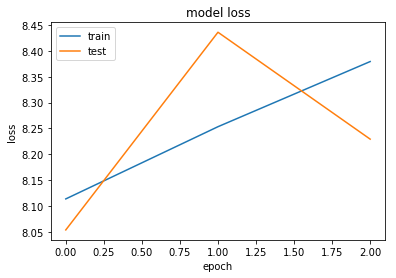

In [64]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [66]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
 
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 


In [ ]:
n_words

In [68]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)
 
# load cleaned text sequences
in_filename = '/Users/neilwatt/Documents/BIs/PrWeb/2018Posts/October/Word_LSTM/gone_with_wind_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1
 
# load the model
model = load_model('weights.hdf5')
 
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
 
# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')
 
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 30)
print(generated)

have you the gall to face me oh you are the most shall we let the bugles sing truce he smiled

the body the body the body the body the body the body the body the body the body the body the body the body the body the body the body


In [ ]:
seed_text